In [1]:
from bs4 import BeautifulSoup
import boto3
import config as cfg
import datetime 
import io
import numpy as np
import pandas as pd
import re
import seaborn as sns
import time
from urllib.parse import urlparse
import yaml

In [2]:
%run "../libraries/aws_utils.ipynb"

In [3]:
%run "../libraries/general_utils.ipynb"

In [4]:
with open('../data_engineering/config.yml', 'r') as file:
   config_files = yaml.safe_load(file)

## Load file with counts of pronouns in each Wiki article

In [5]:
s3_reader = boto3.resource('s3',
                    region_name='us-east-1',
                    aws_access_key_id=cfg.aws_reader['accessCode'],
                    aws_secret_access_key=cfg.aws_reader['secretCode'])

In [6]:
pronoun_data = read_parquet_file(s3_reader, 
                                  config_files['INTEREDIARY_OUTPUT_BUCKET'], 
                      config_files['EXTRACTED_PRONOUNS'],
                                          )
test_primary_key(pronoun_data, ['article_id', 'file_name'])

In [7]:
original_rows = pronoun_data.shape[0]
pronoun_data = pronoun_data[pronoun_data['sum_pronouns']>0]
print(f'Original rows: {original_rows}')
print(f'Rows after dropping articles without pronouns: {pronoun_data.shape[0]}')

Original rows: 566
Rows after dropping articles without pronouns: 482


## Infer gender based on pronoun that occurs most frequently in article

* In Costa-jussà et al. (2019), "the gender of the article is extracted as that
corresponding to the maximum number of gendered pronouns (i.e., he and she in English) mentioned in the article [...] this method of gender inference
is overwhelmingly accurate, in a random test set of 500 articles, it achieved 100% precision with 97.6% recall"
* Citation: Marta R. Costa-jussà, Pau Li Lin, Cristina España-Bonet: “GeBioToolkit: Automatic Extraction of Gender-Balanced Multilingual Corpus of Wikipedia Biographies”, 2019; [http://arxiv.org/abs/1912.04778 arXiv:1912.04778].

In [8]:
max_pronoun_col = pronoun_data[[ 'num_male_tokens', 'num_female_tokens',
       'num_non_binary_tokens', 'num_neo_tokens']].idxmax(axis=1)
pronoun_data['max_pronoun_column'] = max_pronoun_col
pronoun_data['max_pronoun_column'] = pronoun_data['max_pronoun_column'].apply(lambda x:
                                                                              x.replace("num_", "").replace("_tokens", "") )

In [9]:
pronoun_data['max_pronoun_column'].value_counts()

male          321
female        113
non_binary     48
Name: max_pronoun_column, dtype: int64

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='num_male_tokens'>

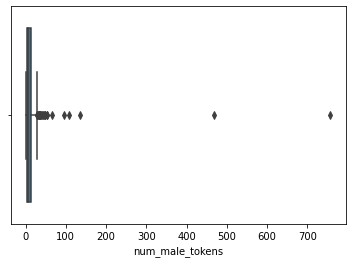

In [10]:
sns.boxplot(pronoun_data[pronoun_data['max_pronoun_column']=="male"]['num_male_tokens'])

In [11]:
pronoun_data.sort_values('num_male_tokens', ascending=False)

,article_id,file_name,scraped_path,entity,found_person,num_entities,afd_result,first_name,last_name,inferred_gender,...,num_male_coreference_tokens,num_female_coreference_tokens,num_non_binary_coreference_tokens,num_neo_coreference_tokens,sum_coreference_pronouns,pct_male_coreference_pronouns,pct_female_coreference_pronouns,pct_non_binary_coreference_pronouns,pct_neo_coreference_pronouns,max_pronoun_column
115,Cristiano_Ronaldo_jr,daily_afd_log/2023-01-18/2023_January_7.txt,individual_afd_page_html/2023-01-15/Cristiano_...,Cristiano Ronaldo jr,True,1,redirect,Cristiano,Ronaldo,male,...,0,0,0,0,0,NaN,NaN,NaN,NaN,male
292,Karl_Heisenberg,daily_afd_log/2023-05-27/2023_May_18.txt,individual_afd_page_html/2023-05-19/Karl_Heise...,Karl Heisenberg,True,1,withdrawn,Karl,Heisenberg,male,...,0,0,0,0,0,NaN,NaN,NaN,NaN,male
436,Po_(Kung_Fu_Panda),daily_afd_log/2023-03-05/2023_February_22.txt,individual_afd_page_html/2023-02-23/Po_(Kung_F...,Po (Kung Fu Panda),True,1,keep,Po,,andy,...,4,0,0,0,4,1.0,0.0,0.0,0.0,male
13,Al_Calavicci,daily_afd_log/2023-03-11/2023_February_28.txt,individual_afd_page_html/2023-03-01/Al_Calavic...,Al Calavicci,True,1,redirect,Al,Calavicci,male,...,151,0,0,0,151,1.0,0.0,0.0,0.0,male
466,Russel_Hobbs,daily_afd_log/2023-03-05/2023_February_22.txt,individual_afd_page_html/2023-02-23/Russel_Hob...,Russel Hobbs,True,1,merge,Russel,Hobbs,male,...,5,0,0,0,5,1.0,0.0,0.0,0.0,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,Isabella_Escobar,daily_afd_log/2023-03-08/2023_February_25.txt,individual_afd_page_html/2023-02-26/Isabella_E...,Isabella Escobar,True,1,delete,Isabella,Escobar,female,...,0,0,0,0,0,NaN,NaN,NaN,NaN,female
464,Romana_Umrianova,daily_afd_log/2023-01-21/2023_January_12.txt,individual_afd_page_html/2023-01-13/Romana_Umr...,Romana Umrianova,True,1,delete,Romana,Umrianova,female,...,0,8,0,0,8,0.0,1.0,0.0,0.0,female
413,Nora_Ariffin,daily_afd_log/2023-01-01/2022_December_21.txt,individual_afd_page_html/2023-01-01/Nora_Ariff...,Nora Ariffin,True,1,speedy keep,Nora,Ariffin,female,...,0,0,0,0,0,NaN,NaN,NaN,NaN,female
232,Iyanla_Bailey-Williams,daily_afd_log/2023-03-09/2023_February_26.txt,individual_afd_page_html/2023-02-26/Iyanla_Bai...,Iyanla Bailey-Williams,True,1,soft delete,Iyanla,Bailey-Williams,unknown,...,0,0,0,0,0,NaN,NaN,NaN,NaN,female


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='num_female_tokens'>

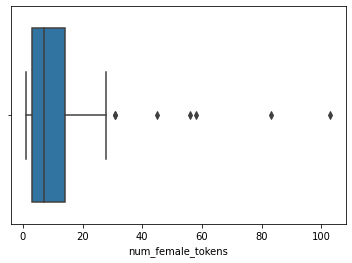

In [12]:
sns.boxplot(pronoun_data[pronoun_data['max_pronoun_column']=="female"]['num_female_tokens'])

In [13]:
s3_writer = boto3.client('s3',
                    region_name='us-east-1',
                    aws_access_key_id=cfg.aws_writer['accessCode'],
                    aws_secret_access_key=cfg.aws_writer['secretCode'])

In [14]:
out_buffer = io.BytesIO()
pronoun_data[['article_id', 'file_name', 'scraped_path',
              'num_male_tokens', 'num_female_tokens',
       'num_non_binary_tokens', 'num_neo_tokens',
              'max_pronoun_column']].to_parquet(out_buffer, index=False)
s3_writer.put_object( Bucket=config_files['INTEREDIARY_OUTPUT_BUCKET'], 
                     Key=config_files['INFERRED_GENDER_BY_PRONOUN_COUNT'], 
                     Body=out_buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'HNP0QMNGNTSWETAG',
  'HostId': 'V2gxzDjp98dFHPUpG1RD2v4XDbn1slhWpXdfBNoojwSoPSWUjozdQAgoZaJjkS4HWYttCp++oGw=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'V2gxzDjp98dFHPUpG1RD2v4XDbn1slhWpXdfBNoojwSoPSWUjozdQAgoZaJjkS4HWYttCp++oGw=',
   'x-amz-request-id': 'HNP0QMNGNTSWETAG',
   'date': 'Sat, 24 Jun 2023 23:39:10 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"035e816beaab884ffaa93153f4213a4e"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"035e816beaab884ffaa93153f4213a4e"',
 'ServerSideEncryption': 'AES256'}

## Infer gender based on most common coreferenced token

In [15]:
coroeference_data = pronoun_data[pronoun_data['sum_coreference_pronouns']>0]

In [16]:
max_coref_pronoun_col = coroeference_data[[ 'num_male_coreference_tokens',
       'num_female_coreference_tokens', 'num_non_binary_coreference_tokens',
       'num_neo_coreference_tokens']].idxmax(axis=1)
coroeference_data['max_coref_pronoun_column'] = max_coref_pronoun_col
coroeference_data['max_coref_pronoun_column'] = coroeference_data['max_coref_pronoun_column'].apply(lambda x:
                                                                              x.replace("num_", "").replace("coreference_tokens_", "") )

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [17]:
coroeference_data['max_coref_pronoun_column'].value_counts()

male_coreference_tokens          119
female_coreference_tokens         47
non_binary_coreference_tokens      1
Name: max_coref_pronoun_column, dtype: int64

In [18]:
out_buffer = io.BytesIO()
coroeference_data[['article_id', 'file_name', 'scraped_path',
        'num_male_coreference_tokens',
       'num_female_coreference_tokens', 'num_non_binary_coreference_tokens',
       'num_neo_coreference_tokens',
              'max_coref_pronoun_column']].to_parquet(out_buffer, index=False)
s3_writer.put_object( Bucket=config_files['INTEREDIARY_OUTPUT_BUCKET'], 
                     Key=config_files['INFERRED_GENDER_BY_COREFERENCE_PRONOUN_COUNT'], 
                     Body=out_buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'HNP3GZMB0MDX75BX',
  'HostId': '810pSEjVrKXfVnBNk2DryidQx2dqMjGMWz6wuJ/rgxdBdllkIYW2b3aZfMmq66S819GzGVRLpck=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '810pSEjVrKXfVnBNk2DryidQx2dqMjGMWz6wuJ/rgxdBdllkIYW2b3aZfMmq66S819GzGVRLpck=',
   'x-amz-request-id': 'HNP3GZMB0MDX75BX',
   'date': 'Sat, 24 Jun 2023 23:39:10 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"46fc7c745c9c9fd6517d148df491a48f"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"46fc7c745c9c9fd6517d148df491a48f"',
 'ServerSideEncryption': 'AES256'}